### Install packages

In [1]:
!pip install python-binance
!pip install joblib


You should consider upgrading via the 'python -m pip install --upgrade pip' command.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


### Imports

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import datetime
import os.path
import math
import argparse
import json
import joblib
from binance.client import Client
#from datetime import datetime
from dateutil import parser as par
from sklearn import preprocessing

### Parameters

In [3]:
#Model Variables
history_points = 14
scaler_x_filename = "x_scaler.save"
scaler_td_filename = "td_scaler.save"
scaler_ti_filename = "ti_scaler.save"

## Util

### CSV To Dataset

In [4]:
def csv_to_dataset(csv_path):
    print(csv_path)
    data = pd.read_csv(csv_path)

    #remove columns that are not needed
    #timestamp, close_time, quote_av, trades, tb_base_av, tb_quote_av, ignore
    data = data.drop('counter', axis=1)
    data = data.drop('timestamp', axis=1)
    data = data.drop('close_time', axis=1)
    data = data.drop('quote_av', axis=1)
    data = data.drop('trades', axis=1)
    data = data.drop('tb_base_av', axis=1)
    data = data.drop('tb_quote_av', axis=1)
    data = data.drop('ignore', axis=1)

    td_data = data
    data = data.drop('td', axis=1)

    #Split the data into train and test sets before normalization
    test_split = 0.9
    n = int(len(data) * test_split)

    d_train = data[:n]
    td_train = td_data[:n]
    d_test = data[n:]
    td_test = td_data[n:]

    #Scale the data. Test data is scaled separately but with the same scaling parameters as the test data
    data_normaliser = preprocessing.MinMaxScaler()
    train_normalised = data_normaliser.fit_transform(d_train)
    test_normalised = data_normaliser.transform(d_test)

    #Save the scaler to scale new data for predictions
    joblib.dump(data_normaliser, scaler_x_filename)

    #Get the data ready for model consumption
    #using the last {history_points} open high low close volume data points, predict the next open value
    #ohlcv_histories_normalised is a three dimensional array of size (len(data_normalised), history points, 5(open, high, low, close, volume))
    #Each item in the list is an array of 50 days worth of ohlcv
    ohlcv_train = np.array([train_normalised[i:i + history_points].copy() for i in range(len(train_normalised) - history_points)])
    ohlcv_test = np.array([test_normalised[i:i + history_points].copy() for i in range(len(test_normalised) - history_points)])

    #Values model is trying to predict
    y_train = np.array(td_train['td'])
    y_train = np.expand_dims(y_train, -1)
    #Strip of initial history_points amount of data points since the model needs atleast history_points history
    y_train = y_train[history_points:]


    y_test = np.array(td_test['td'])
    y_test = np.expand_dims(y_test, -1)
    #Strip of initial history_points amount of data points since the model needs atleast history_points history
    y_test = y_test[history_points:]

    #Scale the data. Test data is scaled separately but with the same scaling parameters as the test data
    td_normaliser = preprocessing.MinMaxScaler()
    y_train = td_normaliser.fit_transform(y_train)
    y_test = td_normaliser.transform(y_test)

    #Save the scaler to scale new data for predictions
    joblib.dump(td_normaliser, scaler_td_filename)

    #tis - technical indicators
    tis_train = []
    tis_test = []
    for his in ohlcv_train:
        # note since we are using his[3] we are taking the SMA of the closing price
        sma = np.mean(his[:, 3])
        tis_train.append(np.array([sma]))
    for his in ohlcv_test:
        sma = np.mean(his[:, 3])
        tis_test.append(np.array([sma]))

    tis_train = np.array(tis_train)
    tis_test = np.array(tis_test)

    indicator_normaliser = preprocessing.MinMaxScaler()
    tis_normalised_train = indicator_normaliser.fit_transform(tis_train)
    tis_normalised_test = indicator_normaliser.transform(tis_test)

    #Save the scaler of the technical indicators
    joblib.dump(indicator_normaliser, scaler_ti_filename)

    #assert ohlcv_histories_normalised.shape[0] == next_day_open_values_normalised.shape[0] == technical_indicators_normalised.shape[0]
    #return ohlcv_histories_normalised, technical_indicators_normalised, next_day_open_values_normalised, next_day_open_values, y_normaliser

    return ohlcv_train, \
        ohlcv_test, \
        y_train, \
        y_test, \
        tis_normalised_train, \
        tis_normalised_test, \
        data

### Save Data To CSV

In [61]:
def get_all_binance(symbol, kline_size, data_type, save = True):
    #https://medium.com/swlh/retrieving-full-historical-data-for-every-cryptocurrency-on-binance-bitmex-using-the-python-apis-27b47fd8137f

    def time_differencing(td_data_df):
      for i in td_data_df.index:
        if i < len(td_data_df)-1:
            td_data_df.loc[i,"td"] = float(td_data_df.loc[i+1,"open"]) - float(td_data_df.loc[i, "open"])
        else:
            td_data_df.loc[i,'td'] = 0
      return td_data_df

    #Only download new data instead of downloading the entire set every runtime
    def minutes_of_new_data(symbol, kline_size, data, client, source):
        if len(data) > 0:
            #Sometimes the last value becomes void, always drop the last value just in case
            data.drop(data.tail(1).index,inplace=True)
            old = par.parse(data["timestamp"].iloc[-1])
        elif source == "binance":
            old = datetime.datetime.strptime('1 Jan 2017', '%d %b %Y')
        if source == "binance":
            new = pd.to_datetime(binance_client.get_klines(symbol=symbol, interval=kline_size)[-1][0], unit='ms')

        return old, new 
    
    ### API
    binance_api_key = "JHiOfaAiYmC2uQVeaPPlNZH1SGZCazrRKX1wDU0ahBIq5omUPoWbE73yWXx663PW"
    binance_api_secret = "R82RLAUqbsvBmuy9e58U5QU8GFWDgvDVJx2oc6bLx4n4MQ5qEguFYHeoNY5uoMyz"
    binance_client = Client(api_key=binance_api_key, api_secret=binance_api_secret)

    #Variables
    binsizes = {"1m": 1, "5m": 5, "1h": 60, "1d": 1440}

    #If file exists, read it, otherwise create new object
    if os.path.isfile(csv_path):
        data_df = pd.read_csv(csv_path)
    else:
        data_df = pd.DataFrame()
    
    def new_data_info(oldest_point, newest_point):
        #Kline/Candlestick chart intervals:
        #m -> minutes; h -> hours; d -> days; w -> weeks; M -> months
        #1m
        #3m
        #5m
        #15m
        #30m
        #1h
        #2h
        #4h
        #6h
        #8h
        #12h
        #1d
        #3d
        #1w
        #1M

        if kline_size == "1h":
            offset = datetime.timedelta(hours=1)
            seconds_in_interval = 3600
        if kline_size == "4h":
            offset = datetime.timedelta(hours=4)
            seconds_in_interval = 14400
        elif kline_size == "1d":
            offset = datetime.timedelta(days=1)
            seconds_in_interval = 86400

        next_needed_point = oldest_point + offset
        delta = (newest_point - next_needed_point).total_seconds()/seconds_in_interval

        if next_needed_point == datetime.datetime.strptime('1 Jan 2017', '%d %b %Y'):
            print('Downloading all available %s data for %s. Be patient..!' % (kline_size, symbol))
        else:
            print('Attempting to downloading %d new instances of %s data available for %s.' % (delta, kline_size, symbol))
        return next_needed_point


    #Perform checks for only downloading new data
    oldest_point, newest_point = minutes_of_new_data(symbol, kline_size, data_df, binance_client, source = "binance")
    next_needed_point = new_data_info(oldest_point, newest_point)
    
    klines = binance_client.get_historical_klines(symbol, kline_size, next_needed_point.strftime("%d %b %Y %H:%M:%S"), newest_point.strftime("%d %b %Y %H:%M:%S"))
    data = pd.DataFrame(klines, columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'ignore' ])
    data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')
    if len(data_df) > 0:
        if(oldest_point != newest_point):
            temp_df = pd.DataFrame(data)
            data_df = data_df.append(temp_df, sort=False, ignore_index = True)
    else:
        data_df = data

    #Create column allowing for referincing index by an int
    x = 0
    print("Creating reference column")
    for i in data_df.index:
        data_df.loc[i, 'counter'] = x
        x = x+1
    data_df.set_index('counter', inplace=True)

    if save:
        if data_type == "td": #Saved format will be time differenced
            print("Computing the delta in price for each datapoint to the next")
            data_df = time_differencing(data_df)
        data_df.to_csv(csv_path)
        
    print('All caught up..!')

# Main

### Download latest data to csv

In [102]:
##Environment variables
symbol = "ETHUSDT"      #Crypto pair on binance
kline_size = "1d"       #1h or 1d
data_type = "td"        #reg or td
save = True             #Save data to csv file
csv_path = "C:\\Users\\Kyler\\Documents\\Visual Studio Code\\crypto-ml\\data\\" + symbol + "-" + kline_size + "-data-" + data_type + ".csv"
get_all_binance(symbol, kline_size, data_type, save)

Attempting to downloading 0 new instances of 1d data available for ETHUSDT.
Creating reference column
Computing the delta in price for each datapoint to the next
All caught up..!


### Extract data from CSV

In [103]:
ohlcv_histories_train, ohlcv_histories_test, y_train, y_test, tech_ind_train, tech_ind_test, data = csv_to_dataset(csv_path)

C:\Users\Kyler\Documents\Visual Studio Code\crypto-ml\data\ETHUSDT-1d-data-td.csv


In [110]:
#This cell is used to manipulate the data and verify contents
intervals = len(data)
increase_counter = 0
increase_amount = 1.02
decrease_amount = 0.98
decrease_counter = 0
for i in data.index:
    if i < intervals-1:
        increase_to_check = increase_amount*data.loc[i,"close"]
        decrease_to_check = decrease_amount*data.loc[i,"close"]
        if increase_to_check <= data.loc[i+1,"high"]:
            increase_counter = increase_counter+1
        elif decrease_to_check >= data.loc[i+1,"low"]:
            decrease_counter = decrease_counter+1
increase_percent = (increase_counter/intervals) * 100
decrease_percent = (decrease_counter/intervals) * 100
#print('Attempting to downloading %d new instances of %s data available for %s.' % (delta, kline_size, symbol))
print('There are {:.0f}/{:.0f} ({:.2f}%) intervals where the price went up atleast {:.0f}% in the next interval'.format(increase_counter, intervals, increase_percent, (increase_amount-1)*100))
print('There are {:.0f}/{:.0f} ({:.2f}%) intervals where the price went down atleast {:.0f}% in the next interval'.format(decrease_counter, intervals, decrease_percent, (1-decrease_amount)*100))

There are 513/912 (56.25%) intervals where the price went up atleast 2% in the next interval
There are 323/912 (35.42%) intervals where the price went down atleast 2% in the next interval


### Build the Model

In [9]:
# define two sets of inputs
lstm_input = tf.keras.layers.Input(shape=(history_points, 5), name='lstm_input')
dense_input = tf.keras.layers.Input(shape=(tech_ind_train.shape[1],), name='tech_input')

# the first branch operates on the first input
x = tf.keras.layers.LSTM(history_points, name='lstm_0')(lstm_input)
x = tf.keras.layers.Dropout(0.2, name='lstm_dropout_0')(x)
lstm_branch = tf.keras.models.Model(inputs=lstm_input, outputs=x)

# the second branch opreates on the second input
y = tf.keras.layers.Dense(20, name='tech_dense_0')(dense_input)
y = tf.keras.layers.Activation("relu", name='tech_relu_0')(y)
y = tf.keras.layers.Dropout(0.2, name='tech_dropout_0')(y)
technical_indicators_branch = tf.keras.models.Model(inputs=dense_input, outputs=y)

# combine the output of the two branches
combined = tf.keras.layers.concatenate([lstm_branch.output, technical_indicators_branch.output], name='concatenate')

z = tf.keras.layers.Dense(64, activation="sigmoid", name='dense_pooling')(combined)
z = tf.keras.layers.Dense(1, activation="linear", name='dense_out')(z)

# our model will accept the inputs of the two branches and
# then output a single value
model = tf.keras.models.Model(inputs=[lstm_branch.input, technical_indicators_branch.input], outputs=z)
adam = tf.keras.optimizers.Adam(lr=0.0005)
model.compile(optimizer=adam, loss='mse')

### Train Model

In [10]:
bs = 1024
e = 100
restore_model = False

#logging for tensorboard
log_dir= os.path.join(
    "logs",
    "fit",
    datetime.now().strftime("%Y%m%d-%H%M%S"),
)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

if(restore_model):
    model = tf.keras.models.load_model('technical_model.h5')

else:
    #print(ohlcv_histories_train)
    model.fit(x=[ohlcv_histories_train, tech_ind_train],
          y=y_train,
          batch_size=bs,
          epochs=e,
          shuffle=True,
          validation_split=0.2,
          callbacks=[tensorboard_callback]
    )

Train on 624 samples, validate on 157 samples
Epoch 1/100
624/624 [==============================] - 4s 7ms/sample - loss: 0.1367 - val_loss: 0.1270
Epoch 2/100
624/624 [==============================] - 0s 99us/sample - loss: 0.1220 - val_loss: 0.1135
Epoch 3/100
624/624 [==============================] - 0s 37us/sample - loss: 0.1085 - val_loss: 0.1007
Epoch 4/100
624/624 [==============================] - 0s 40us/sample - loss: 0.0959 - val_loss: 0.0887
Epoch 5/100
624/624 [==============================] - 0s 38us/sample - loss: 0.0840 - val_loss: 0.0776
Epoch 6/100
624/624 [==============================] - 0s 40us/sample - loss: 0.0734 - val_loss: 0.0673
Epoch 7/100
624/624 [==============================] - 0s 37us/sample - loss: 0.0632 - val_loss: 0.0579
Epoch 8/100
624/624 [==============================] - 0s 38us/sample - loss: 0.0539 - val_loss: 0.0492
Epoch 9/100
624/624 [==============================] - 0s 45us/sample - loss: 0.0469 - val_loss: 0.0415
Epoch 10/100
624/62

### Evaluate the model

114.78051004220924


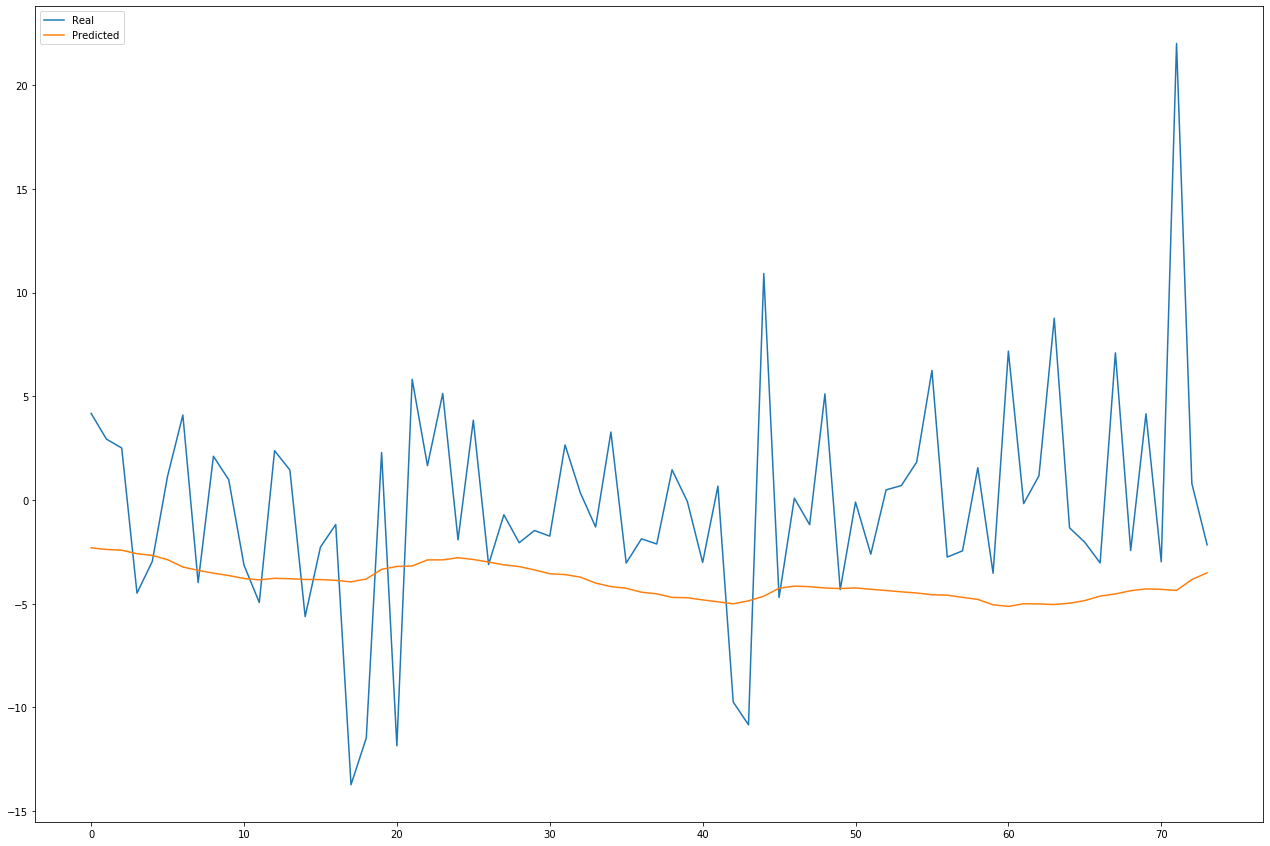

In [11]:
#Load in the scalers
data_scaler = joblib.load(scaler_x_filename)
tis_scaler = joblib.load(scaler_ti_filename)
td_scaler = joblib.load(scaler_td_filename)

# evaluation

y_test_predicted = model.predict([ohlcv_histories_test, tech_ind_test])
y_test_predicted = td_scaler.inverse_transform(y_test_predicted)
y_predicted = model.predict([ohlcv_histories_train, tech_ind_train])
y_predicted = td_scaler.inverse_transform(y_predicted)
y_train = td_scaler.inverse_transform(y_train)
y_test = td_scaler.inverse_transform(y_test)
assert y_test.shape == y_test_predicted.shape

real_mse = np.mean(np.square(y_test - y_test_predicted))
scaled_mse = real_mse / (np.max(y_test) - np.min(y_test)) * 100
print(scaled_mse)

import matplotlib.pyplot as plt

plt.gcf().set_size_inches(22, 15, forward=True)

start = 0
end = -1

real = plt.plot(y_test[start:end], label='real')
pred = plt.plot(y_test_predicted[start:end], label='predicted')

#real = plt.plot(y_train[start:end], label='real_train')
#pred = plt.plot(y_predicted[start:end], label='predicted_train')
plt.legend(['Real', 'Predicted'])

plt.savefig("test_data.png")
plt.show()

from datetime import datetime
model.save(f'technical_model.h5')